In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [2]:
# convert data to a normalized torch.FloatTensor
transform = {
    "train": transforms.Compose([
        transforms.RandomHorizontalFlip(0.5), 
        transforms.RandomGrayscale(0.1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "test": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

In [3]:
# how many samples per batch to load
batch_size = 100

# choose the training and test datasets
train_data = datasets.CIFAR10('data3', train=True, download=True, transform=transform["train"])
test_data = datasets.CIFAR10('data3', train=False, download=True, transform=transform["test"])

Files already downloaded and verified


In [4]:
# percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
training_examples = len(train_data)
indices = list(range(training_examples))
np.random.shuffle(indices)
split = int(np.floor(valid_size * training_examples))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [5]:
# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

In [9]:
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        # Batch normalization
        self.norm1 = nn.BatchNorm2d(16)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        # Batch normalization
        self.norm2 = nn.BatchNorm2d(32)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1)
        # Batch normalization
        self.norm3 = nn.BatchNorm2d(64)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # Batch normalization
        self.norm4 = nn.BatchNorm1d(500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.20)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(self.norm1(F.relu(self.conv1(x))))
        x = self.pool(self.norm2(F.relu(self.conv2(x))))
        x = self.pool(self.norm3(F.relu(self.conv3(x))))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = self.norm4(F.relu(self.fc1(x)))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

In [10]:
# create a complete CNN
model = Net()

# specify loss function (categorical cross-entropy)
criterion = nn.NLLLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

# number of epochs to train the model
epochs = 100

In [11]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []
x_axis = []

for e in range(1, epochs+1):
    running_loss = 0
    running_acc = 0
    iterations = 0
    
    model.train()
    for data, target in train_loader:
        iterations += 1

        log_ps = model(data)
        loss = criterion(log_ps, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(target, top_class)
        
    dev_running_loss = 0
    acc = 0
    iter_2 = 0
        
    if e%5 == 0 or e == 1:
        x_axis.append(e)
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for data_dev, target_dev in valid_loader:
                iter_2 += 1
                log_dev = model(data_dev)
                dev_loss = criterion(log_dev, target_dev)
                dev_running_loss += dev_loss.item()

                ps_dev = torch.exp(log_dev)
                top_p, top_class_dev = ps_dev.topk(1, dim=1)
                acc += accuracy_score(target_dev, top_class_dev)
        
        train_losses.append(running_loss/iterations)
        dev_losses.append(dev_running_loss/iter_2)
        train_acc.append(running_acc/iterations)
        dev_acc.append(acc/iter_2)
        
        print("Epoch: {}/{}.. ".format(e, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/iterations),
              "Validation Loss: {:.3f}.. ".format(dev_running_loss/iter_2),
              "Training Accuracy: {:.3f}.. ".format(running_acc/iterations),
              "Validation Accuracy: {:.3f}".format(acc/iter_2))

Epoch: 1/100..  Training Loss: 1.631..  Validation Loss: 1.374..  Training Accuracy: 0.417..  Validation Accuracy: 0.525
Epoch: 5/100..  Training Loss: 1.041..  Validation Loss: 1.019..  Training Accuracy: 0.633..  Validation Accuracy: 0.633
Epoch: 10/100..  Training Loss: 0.866..  Validation Loss: 0.837..  Training Accuracy: 0.696..  Validation Accuracy: 0.709
Epoch: 15/100..  Training Loss: 0.773..  Validation Loss: 0.780..  Training Accuracy: 0.728..  Validation Accuracy: 0.729
Epoch: 20/100..  Training Loss: 0.699..  Validation Loss: 0.726..  Training Accuracy: 0.755..  Validation Accuracy: 0.745
Epoch: 25/100..  Training Loss: 0.646..  Validation Loss: 0.704..  Training Accuracy: 0.774..  Validation Accuracy: 0.753
Epoch: 30/100..  Training Loss: 0.600..  Validation Loss: 0.649..  Training Accuracy: 0.790..  Validation Accuracy: 0.771
Epoch: 35/100..  Training Loss: 0.560..  Validation Loss: 0.641..  Training Accuracy: 0.803..  Validation Accuracy: 0.776
Epoch: 40/100..  Training 

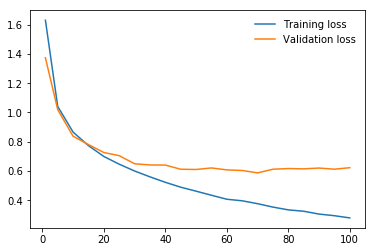

In [12]:
plt.plot(x_axis,train_losses, label='Training loss')
plt.plot(x_axis, dev_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

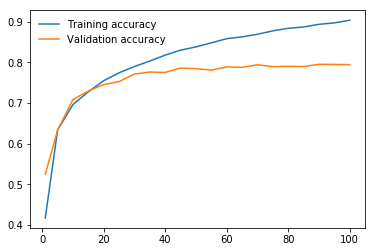

In [13]:
plt.plot(x_axis, train_acc, label="Training accuracy")
plt.plot(x_axis, dev_acc, label="Validation accuracy")
plt.legend(frameon=False)
plt.show()

In [14]:
model.eval()
iter_3 = 0
acc_test = 0
for data_test, target_test in test_loader:
    iter_3 += 1
    test_pred = model(data_test)
    test_pred = torch.exp(test_pred)
    top_p, top_class_test = test_pred.topk(1, dim=1)
    acc_test += accuracy_score(target_test, top_class_test)
print(acc_test/iter_3)

0.8011999999999999
